# Implementing a CGAN for the Titanic data set to generate synthetic data
### Import necessary modules and packages

In [1]:
import os
while os.path.basename(os.getcwd()) != 'Synthetic_Data_GAN_Capstone':
    os.chdir('..')
from utils.utils import *
safe_mkdir('experiments')
from utils.data_loading import load_raw_dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from models.CGAN_titanic import CGAN_Generator, CGAN_Discriminator
import random

### Set random seem for reproducibility

In [2]:
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


### Import and briefly inspect data

In [3]:
titanic = pd.read_csv('data/titanic/cleaned.csv')
titanic.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,CabinLetter,Title,Age
0,0,3,male,1,0,7.2500,S,NoCabin,Mr.,22.0
1,1,1,female,1,0,71.2833,C,C,Mrs.,38.0
2,1,3,female,0,0,7.9250,S,NoCabin,Miss.,26.0
3,1,1,female,1,0,53.1000,S,C,Mrs.,35.0
4,0,3,male,0,0,8.0500,S,NoCabin,Mr.,35.0


### Preprocessing data
This data set is more complicated than iris and wine because it contains categorical variables. This presented numerous challenges for the GAN. Since neural networks can't directly handle categorical variables, these features need to be one-hot encoded. In order to properly represent one-hot encoded features from the generator's perspective, a softmax activation was used for each distinct categorical feature. Since we will be treating categorical features so differently from continuous ones, I am going to explicitly call out that these features are different by creating a named list, and rearrange the order so that the continuous features are at the end.

In [4]:
cont_inputs = ['SibSp', 'Parch', 'Fare', 'Age']
cat_inputs = np.array([x for x in titanic.drop(columns='Survived').columns if x not in cont_inputs])
int_inputs = ['SibSp', 'Parch']

In [5]:
cols = titanic.columns.tolist()
cols_start = ['Survived'] + list(cat_inputs)
cols = cols_start + [x for x in cols if x not in cols_start]
titanic = titanic[cols]

Next, we are going to create a boolean mask that is True when a categorical feature is present and False when a continuous one is present. This will be used throughout the remainder of the code for convenience.

In [6]:
cat_mask = ~np.array([x in cont_inputs for x in titanic.drop(columns='Survived').columns])

Now we continue by splitting the data roughly 50/50 so we can demonstrate the effectiveness of additional data.

In [7]:
x_train, x_test, y_train, y_test = train_test_split(titanic.drop(columns='Survived'), titanic['Survived'],
                                                    test_size=445, stratify=titanic['Survived'], random_state=manualSeed)
print("x_train:", x_train.shape)
print("x_test:", x_test.shape)

x_train: (446, 9)
x_test: (445, 9)


Now, I am going to one_hot encode all of the categorical variables. While typically one might call pd.get_dummies(), I need to be able to perform an inverse transformation later on, so I am going to use sklearn's LabelEncoder for each categorical variable, followed by sklearn's OneHotEncoder. These are wrapped up in a helper function that you can check out in the Utils file. I am also being careful to apply the same transformation to x_train and x_test here.

In [8]:
le_dict, ohe, x_train, x_test = encode_categoricals_custom(titanic, x_train, x_test, cat_inputs, cat_mask)
print("x_train:", x_train.shape)
print("x_test:", x_test.shape)

x_train: (446, 26)
x_test: (445, 26)


/home/aj/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:414: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/aj/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:450: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


Now that the data has been transformed to include one hot encoded features, I need to create an additional boolean mask that signals when a given column is really part of a categorical feature.

In [9]:
preprocessed_cat_mask = create_preprocessed_cat_mask(le_dict=le_dict, x_train=x_train)

Next, I will scale the continuous inputs as is typically done for training neural networks.

In [10]:
x_train, scaler = scale_cont_inputs(x_train, preprocessed_cat_mask)
x_test, _ = scale_cont_inputs(x_test, preprocessed_cat_mask, scaler=scaler)
x_train_tensor = torch.tensor(x_train, dtype=torch.float)
y_train_dummies = pd.get_dummies(y_train)
y_train_dummies_tensor = torch.tensor(y_train_dummies.values, dtype=torch.float)

I will go ahead and use pd.get_dummies for the dependent variable, primarily because it is a single binary variable, and it is so simple to transform back and forth.

In [11]:
y_test_dummies = pd.get_dummies(y_test)

### Model parameters (feel free to play with these)

In [12]:
nz = 64  # Size of generator noise input
H = 32  # Size of hidden network layer
out_dim = x_train.shape[1]  # Size of output
bs = x_train.shape[0]  # Full data set
nc = 2  # 2 different types of label in this problem
num_batches = 1
num_epochs = 10000
print_interval = 1000
exp_name = 'experiments/titanic_3x32_wd_0_uniform_init_only_gen2'
safe_mkdir(exp_name)

### Adam optimizer hyperparameters

In [13]:
lr = 2e-4
beta1 = 0.5
beta2 = 0.999

### Set the device
GPU seems to be working better this time around.

In [14]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

### Instantiate nets
Feel free to take a look at the differences in code for the titanic CGAN versus the wine and iris CGANs. One thing that made a huge difference was changing the initialization for the generator to use uniform as opposed to the typically recommended normal. This allowed for a greater variety of categorical outputs, which allowed the GAN to better represent all of the possible combinations of features.

In [15]:
netG = CGAN_Generator(nz=nz, H=H, out_dim=out_dim, nc=nc, bs=bs, device=device, wd=0, cat_mask=preprocessed_cat_mask, le_dict=le_dict).to(device)
netD = CGAN_Discriminator(H=H, out_dim=out_dim, nc=nc, device=device, wd=0).to(device)

### Print models
Another interesting thing to point out is that I had to implement my own custom layer for the generator in order to properly handle categorical variables. You can find the code for it in the NetUtils.py file.

In [16]:
print(netG)
print(netD)

CGAN_Generator(
  (CCGL): CustomCatGANLayer(
    (sm): Softmax()
  )
  (fc1): Linear(in_features=66, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=26, bias=True)
  (act): LeakyReLU(negative_slope=0.2)
  (sm): Softmax()
  (loss_fn): BCELoss()
)
CGAN_Discriminator(
  (fc1): Linear(in_features=28, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
  (act): LeakyReLU(negative_slope=0.2)
  (m): Sigmoid()
  (loss_fn): BCELoss()
)


### Define labels

In [17]:
real_label = 1
fake_label = 0

### Stratified dependent variable
An additional complexity with this data set is that the classes are not balanced. The probability of dying is approximately 62%. In order to handle this, I use the training set proportion of dependent variables when generating fake data to train on.

In [18]:
train_avg = y_train.mean()
stratify = [1-train_avg, train_avg]
print(stratify)

[0.6165919282511211, 0.3834080717488789]


### Train on real data
First, we will train a model on the real training data in order to develop a benchmark against which to compare models trained on fake data. This will allow us to estimate the performance of our GAN in an unbiased manner.

In [20]:
labels_list = [x for x in y_train_dummies.columns]
param_grid = {'tol': [1e-5],
              'C': [0.5],
              'l1_ratio': [0]}
model_real, score_real = train_test_logistic_reg(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test,
                                                 param_grid=param_grid, cv=5, random_state=manualSeed, labels=labels_list)
print("Model trained on real data achieved an accuracy score of {0:.2f}".format(score_real))

Accuracy: 0.8112359550561797
Best Parameters: {'C': 0.5, 'l1_ratio': 0, 'tol': 1e-05}
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       274
           1       0.78      0.71      0.74       171

    accuracy                           0.81       445
   macro avg       0.80      0.79      0.80       445
weighted avg       0.81      0.81      0.81       445

[[240  34]
 [ 50 121]]
Model trained on real data achieved an accuracy score of 0.81


## Training the GAN
First, let's preallocate some objects for storing training results as we train our GAN. The test_range object represents the various fake data set sizes that we will generate and train our model on in order to compare to our baseline. Remember that our baseline was trained on a data set of size 446.

In [21]:
test_range = [bs*2**x for x in range(5)]
stored_models = []
stored_scores = []
best_score = 0

Now, we can train our model:

In [22]:
print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i in range(num_batches):  # Only one batch per epoch since our data is horrifically small
        # Update Discriminator
        # All real batch first
        real_data = x_train_tensor.to(device)  # Format batch (entire data set in this case)
        real_classes = y_train_dummies_tensor.to(device)
        label = torch.full((bs,), real_label, device=device)  # All real labels

        output = netD(real_data, real_classes).view(-1)  # Forward pass with real data through Discriminator
        netD.train_one_step_real(output, label)

        # All fake batch next
        noise = torch.randn(bs, nz, device=device)  # Generate batch of latent vectors
        fake = netG(noise, real_classes)  # Fake image batch with netG
        # fake = process_fake_output(fake, le_dict)
        label.fill_(fake_label)
        output = netD(fake.detach(), real_classes).view(-1)
        netD.train_one_step_fake(output, label)
        netD.combine_and_update_opt()
        netD.update_history()

        # Update Generator
        label.fill_(real_label)  # Reverse labels, fakes are real for generator cost
        output = netD(fake, real_classes).view(-1)  # Since D has been updated, perform another forward pass of all-fakes through D
        netG.train_one_step(output, label)
        netG.update_history()

    # Output training stats
    if epoch % print_interval == 0 or (epoch == num_epochs-1):
        print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                % (epoch+1, num_epochs, netD.loss.item(), netG.loss.item(), netD.D_x, netD.D_G_z1, netG.D_G_z2))
        with torch.no_grad():
            # Generate various levels of amounts of fake data and test how training compares
            tmp_models, tmp_scores = evaluate_training_progress(test_range=test_range, fake_bs=bs, nz=nz, nc=nc, out_dim=out_dim, netG=netG,
                                                                x_test=x_test, y_test=y_test, manualSeed=manualSeed, labels_list=labels_list,
                                                                param_grid=param_grid, device=device, le_dict=le_dict, stratify=stratify)
        if max(tmp_scores) > best_score:
            best_score = max(tmp_scores)
            torch.save(netG.state_dict(), exp_name + "/best_netG.pt")
        stored_models += tmp_models
        stored_scores += tmp_scores

print("Real data best score:", score_real)
print("GAN best score:", best_score)
if best_score > score_real:
    print("Success! GAN beat real data!")
else:
    print("Failure. GAN did not beat real data...")

Starting Training Loop...
[1/10000]	Loss_D: 1.3856	Loss_G: 0.7152	D(x): 0.4898	D(G(z)): 0.4892 / 0.4891
[1001/10000]	Loss_D: 1.3620	Loss_G: 0.7019	D(x): 0.5090	D(G(z)): 0.4961 / 0.4960
[2001/10000]	Loss_D: 1.3578	Loss_G: 0.7121	D(x): 0.5068	D(G(z)): 0.4913 / 0.4910
[3001/10000]	Loss_D: 1.3475	Loss_G: 0.7139	D(x): 0.5120	D(G(z)): 0.4907 / 0.4904
[4001/10000]	Loss_D: 1.3354	Loss_G: 0.7240	D(x): 0.5136	D(G(z)): 0.4854 / 0.4854
[5001/10000]	Loss_D: 1.3240	Loss_G: 0.7340	D(x): 0.5181	D(G(z)): 0.4817 / 0.4813
[6001/10000]	Loss_D: 1.3278	Loss_G: 0.7312	D(x): 0.5214	D(G(z)): 0.4844 / 0.4836
[7001/10000]	Loss_D: 1.2787	Loss_G: 0.7671	D(x): 0.5281	D(G(z)): 0.4658 / 0.4666
[8001/10000]	Loss_D: 1.2724	Loss_G: 0.7718	D(x): 0.5337	D(G(z)): 0.4652 / 0.4651
[9001/10000]	Loss_D: 1.2634	Loss_G: 0.7874	D(x): 0.5360	D(G(z)): 0.4598 / 0.4597
[10000/10000]	Loss_D: 1.2560	Loss_G: 0.7894	D(x): 0.5401	D(G(z)): 0.4589 / 0.4593
Real data best score: 0.8112359550561797
GAN best score: 0.8224719101123595
Success! 

Wow! It looks like we succeeded in training a model entirely on fake data that could outperform a model trained on the actual data. This supports the idea that the GAN has achieved a good understanding of the underlying data distributions. We will go into detail and visualize different aspects of the model training in order to get a better understanding of what actually took place.

### Plot evaluation over time
First, let's look at how our estimate of model performance evolved as the model trained 10,000 epochs. Note, the red dashed line on the plot represents the performance of the model trained on real data from earlier.

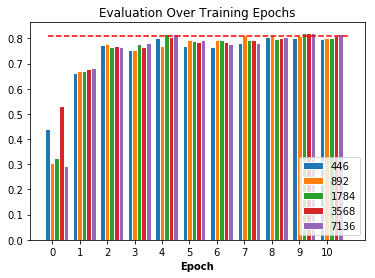

<Figure size 432x288 with 0 Axes>

In [23]:
%matplotlib inline
plot_training_progress(stored_scores=stored_scores, test_range=test_range, num_saves=len(stored_scores) // len(test_range),
                       real_data_score=score_real, save=exp_name)

It appears that our model started off in a pretty terrible state, but by epoch 4000 was able to get a pretty good grasp of the data distribution. It appears that it peaked around epoch 9000 or so. Let's take a quick look at the confusion matrix for our lucky winner.

In [24]:
parse_models(stored_models=stored_models, epoch=9000, print_interval=print_interval, test_range=test_range,
             ind=4, x_test=x_test, y_test=y_test, labels=labels_list)

Accuracy: 0.8224719101123595
Best Parameters: {'C': 0.5, 'l1_ratio': 0, 'tol': 1e-05}
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       274
           1       0.78      0.75      0.76       171

    accuracy                           0.82       445
   macro avg       0.81      0.81      0.81       445
weighted avg       0.82      0.82      0.82       445

[[238  36]
 [ 43 128]]


Comparing the two confusion matrices, it appears that this model was actually slightly worse at predicting death, but better at predicting survival.

### Visualizing model and training diagnostics
Next, let's take a look at some of the training diagnostic plots similar to what we did for the iris and wine data sets.

/home/aj/.local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


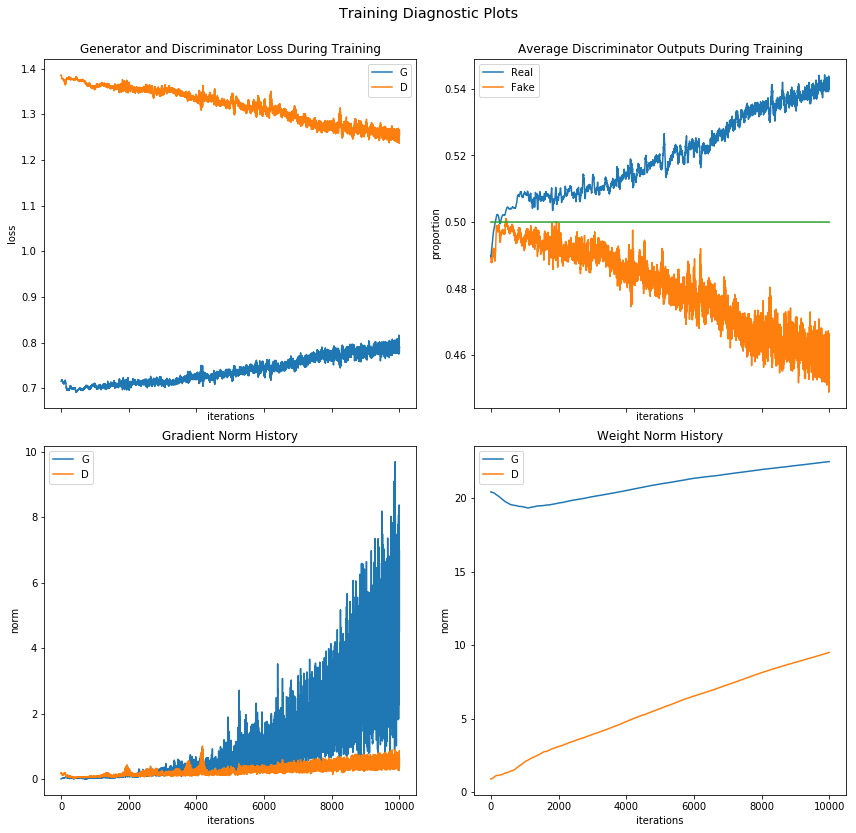

In [25]:
training_plots(netD=netD, netG=netG, num_epochs=num_epochs, save=exp_name)

Top left plot: It is interesting to note that it appears the discriminator is slowly dominating the generator. I wonder what would happen the GAN were allowed to continue training for many more epochs.

Bottom left plot: The gradients of the generator seem to contain high variance. This could be an issue, and perhaps could benefit from some regularization.

Top right plot: The trend of this plot is interesting. It appears that the discriminator is predicting more of the samples to be real versus fake, even though it's loss is steadily decreasing. I would be curious to see what would happen if the model continued to train.

Bottom right plot: The weight norms continue to grow, as seems to be common in these scenarios.

/home/aj/.local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


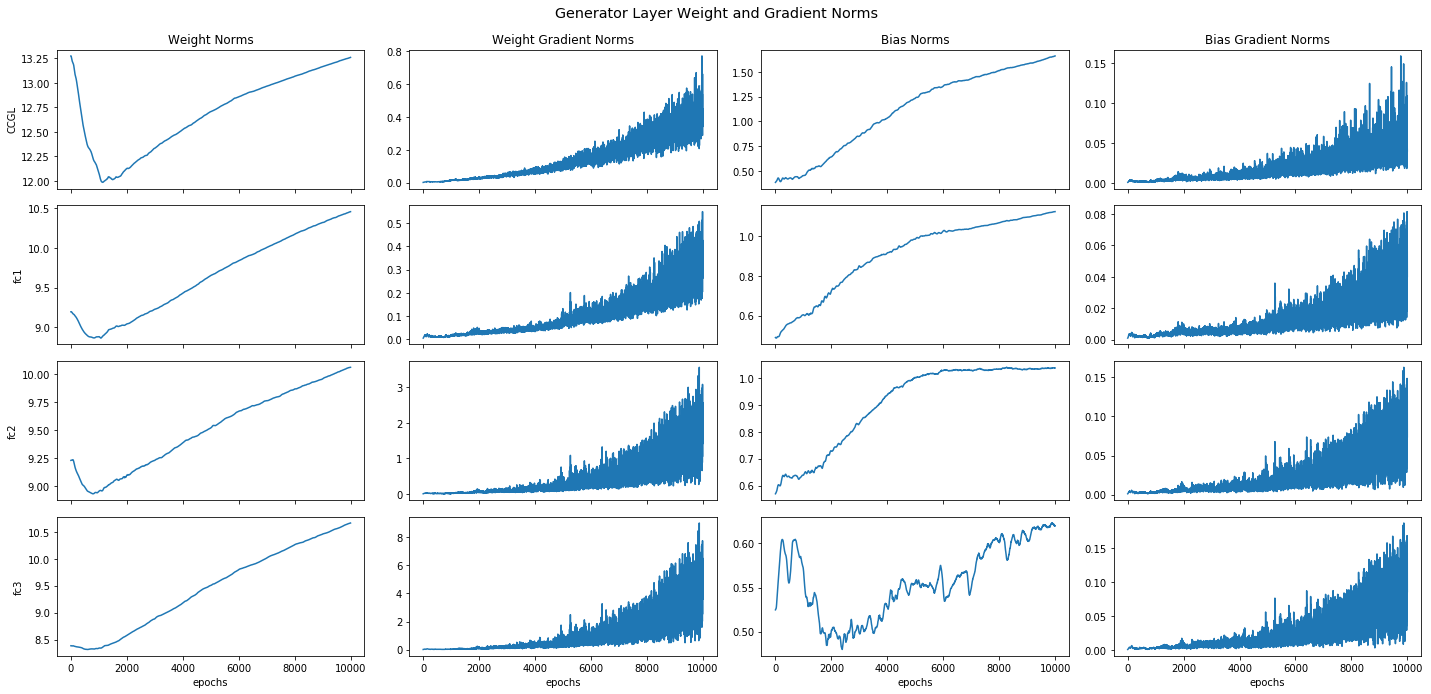

In [26]:
plot_layer_scatters(netG, title="Generator", save=exp_name)

/home/aj/.local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


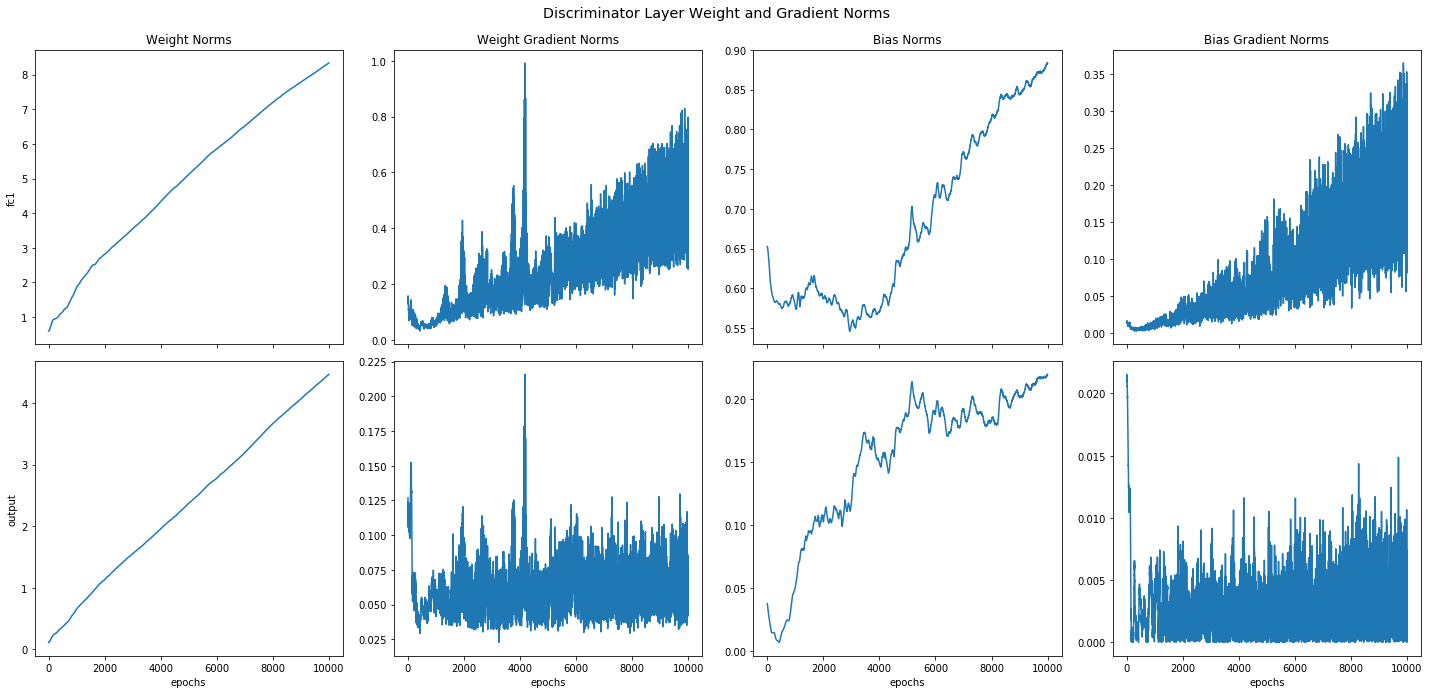

In [27]:
plot_layer_scatters(netD, title="Discriminator", save=exp_name)

These plots give a closer look into each layer and how training is behaving. They are interesting, but I don't feel there is much to say about what is happening here that isn't already gleaned from the initial training plot. Definitely worth checking out for diagnostic purposes.

### Visualizing data distributions and comparing real vs. fake data
Let's load up the best model saved from training earlier to generate a batch of fake data so that we can compare it against the real data.

In [28]:
best_netG = CGAN_Generator(nz=nz, H=H, out_dim=out_dim, nc=nc, bs=bs, device=device, wd=0, cat_mask=preprocessed_cat_mask, le_dict=le_dict).to(device)
best_netG.load_state_dict(torch.load(exp_name + "/best_netG.pt"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

We will fit another model to evaluate its performance, mainly as a sanity check that everything is working correctly and to double check that we didn't just get lucky earlier with our high accuracy.

In [29]:
genned_data, genned_labels = gen_fake_data(netG=best_netG, bs=test_range[3], nz=nz, nc=nc, labels_list=labels_list, device=device, stratify=stratify)
genned_data = process_fake_output(genned_data, le_dict)
model_fake, score_fake = train_test_logistic_reg(genned_data, genned_labels, x_test, y_test, param_grid=param_grid, cv=5, random_state=manualSeed,
                                                 labels=labels_list)

Accuracy: 0.8179775280898877
Best Parameters: {'C': 0.5, 'l1_ratio': 0, 'tol': 1e-05}
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       274
           1       0.78      0.73      0.75       171

    accuracy                           0.82       445
   macro avg       0.81      0.80      0.80       445
weighted avg       0.82      0.82      0.82       445

[[240  34]
 [ 47 124]]


Next, we will transform the generated data back to its original dataframe form.

In [52]:
genned_data_df = fully_process_fake_output(processed_fake_output=genned_data,
                                           genned_labels=genned_labels,
                                           label_name='Survived',
                                           preprocessed_cat_mask=preprocessed_cat_mask,
                                           ohe=ohe,
                                           le_dict=le_dict,
                                           scaler=scaler,
                                           cat_inputs=cat_inputs,
                                           cont_inputs=cont_inputs,
                                           int_inputs=int_inputs)
genned_data_df.sample(5)

,Survived,Pclass,Sex,Embarked,CabinLetter,Title,SibSp,Parch,Fare,Age
1017,0,3,male,S,NoCabin,Mr.,0,0,9.197301,37.816784
677,0,3,male,S,NoCabin,Mr.,0,0,6.408515,39.299545
1912,0,3,male,S,NoCabin,Mr.,0,0,4.999684,26.129530
1586,0,3,female,S,NoCabin,Miss.,3,1,17.802513,8.915092
2876,1,2,female,S,NoCabin,Mrs.,0,0,38.476894,18.886812


In [54]:
titanic.sample(5)

,Survived,Pclass,Sex,Embarked,CabinLetter,Title,SibSp,Parch,Fare,Age
589,1,1,female,C,B,Miss.,2,2,262.3750,21.000000
805,0,3,male,Q,NoCabin,Mr.,0,0,7.7500,35.240716
634,1,3,female,S,NoCabin,Mrs.,0,0,8.6833,31.000000
97,1,2,female,S,E,Miss.,0,0,13.0000,32.500000
450,1,3,male,S,NoCabin,Mr.,0,0,7.8542,32.000000


Looks pretty similar to the original data. Note that I could have rounded the Ages to the nearest whole number, but when we filled in the missing ages with interpolation, more often than not the ages were not integers either. If you hit sample enough times, you may come across odd values, such as SibSp being -1! This could be fixed through additional processing of the data, but interestingly enough was ultimately unnecessary to produce a good model.

In [57]:
genned_data_df.describe()

,Survived,Pclass,SibSp,Parch,Fare,Age
count,3568.000000,3568.000000,3568.000000,3568.000000,3568.000000,3568.000000
mean,0.383408,2.375280,0.450673,0.299888,31.045119,28.623736
std,0.486284,0.816926,1.068881,0.688143,45.315957,12.889992
min,0.000000,1.000000,-1.000000,0.000000,-14.034638,-20.019016
25%,0.000000,2.000000,0.000000,0.000000,8.138505,21.618930
50%,0.000000,3.000000,0.000000,0.000000,16.540300,28.621278
75%,1.000000,3.000000,1.000000,0.000000,38.283872,35.020886
max,1.000000,3.000000,10.000000,7.000000,558.330688,93.619385


In [58]:
titanic.describe()

,Survived,Pclass,SibSp,Parch,Fare,Age
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.523008,0.381594,32.204208,29.700733
std,0.486592,0.836071,1.102743,0.806057,49.693429,13.583528
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.420000
25%,0.000000,2.000000,0.000000,0.000000,7.910400,21.000000
50%,0.000000,3.000000,0.000000,0.000000,14.454200,29.670804
75%,1.000000,3.000000,1.000000,0.000000,31.000000,36.750000
max,1.000000,3.000000,8.000000,6.000000,512.329200,80.000000


Similar to before, let's visualize scatter matrices of the continuous variables of the generated and real data

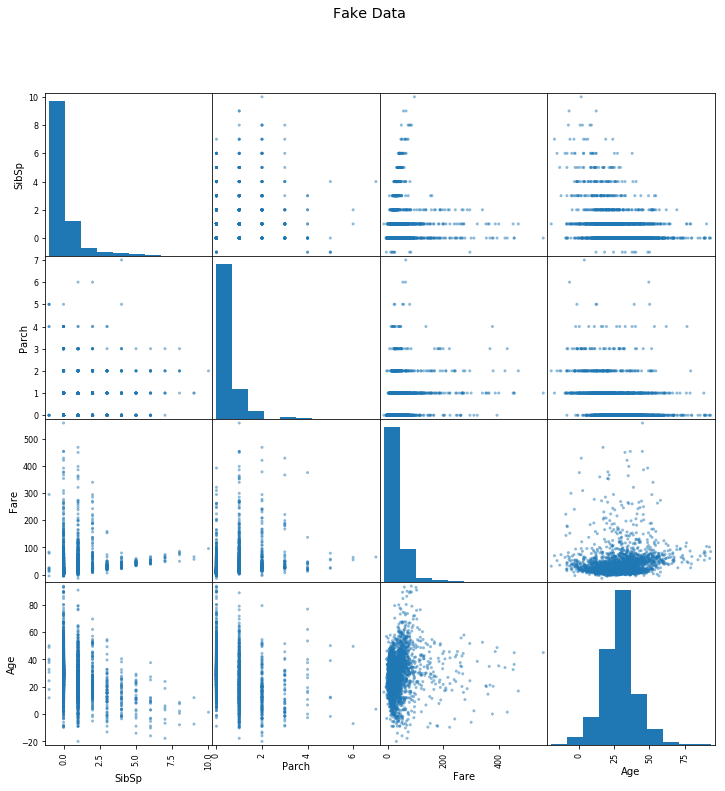

<Figure size 432x288 with 0 Axes>

In [59]:
plot_scatter_matrix(genned_data_df[cont_inputs], "Fake Data", titanic[cont_inputs], scaler=None, save=exp_name)

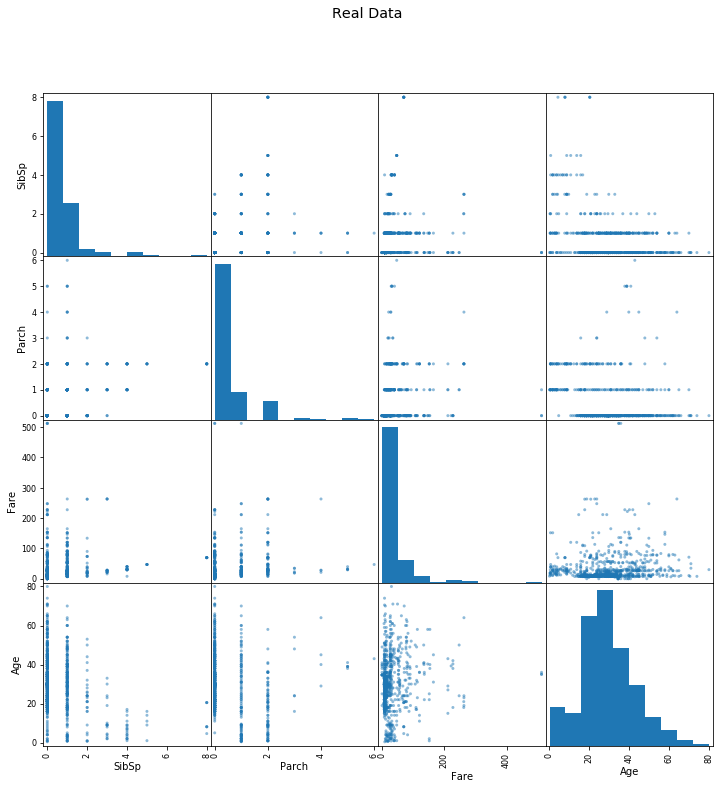

<Figure size 432x288 with 0 Axes>

In [60]:
plot_scatter_matrix(titanic[cont_inputs], "Real Data", titanic[cont_inputs], scaler=None, save=exp_name)

I think it's really interesting overall how it seems like the GAN tries to push the boundaries and produce values outside of the natural range of values as the number of data points increases. Comparing the two data sets, it almost appears as if the GAN data is just a more intense version of the original data.

I also wrote a helper function to visualize the conditional distribution of 2 categorical variables between the real and fake data. Feel free to play around with the x and hue arguments and set them to whichever categorical variables you prefer!

/home/aj/.local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


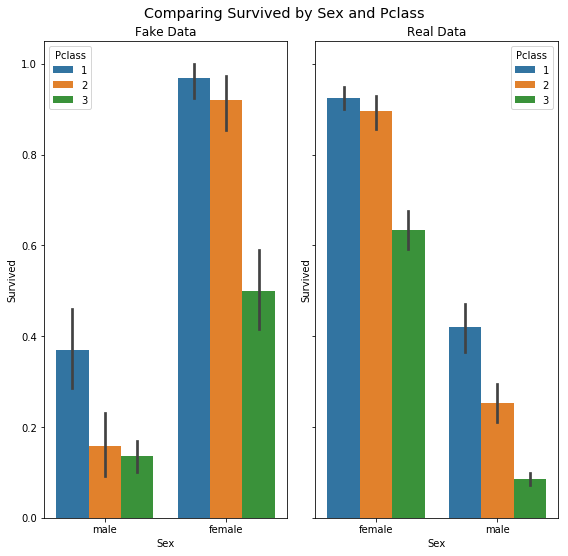

In [66]:
compare_cats(real=titanic, fake=genned_data_df, x='Sex', y='Survived', hue='Pclass', save=exp_name)

Finally, we can also analyze the conditional scatters and densities of the continuous variables. Feel free to play around with the col arguments of these functions!

/home/aj/.local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


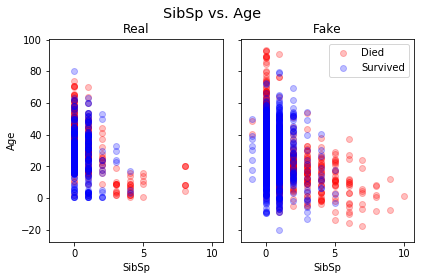

In [72]:
class_dict = {0: ('Died', 'r'),
              1: ('Survived', 'b')}
plot_conditional_scatter(x_real=titanic[cont_inputs].values,
                         y_real=titanic['Survived'].values,
                         x_fake=genned_data_df[cont_inputs].values,
                         y_fake=genned_data_df['Survived'].values,
                         col1=0,
                         col2=3,
                         class_dict=class_dict,
                         og_df=titanic[cont_inputs],
                         scaler=None,
                         alpha=0.25,
                         save=exp_name)

/home/aj/.local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


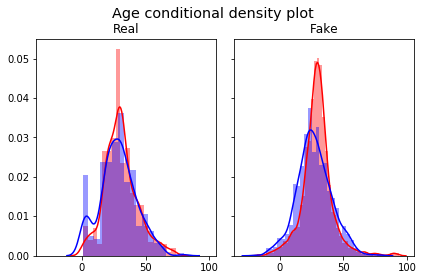

In [73]:
plot_conditional_density(x_real=titanic[cont_inputs].values,
                         y_real=titanic['Survived'].values,
                         x_fake=genned_data_df[cont_inputs].values,
                         y_fake=genned_data_df['Survived'].values,
                         col=3,
                         class_dict=class_dict,
                         og_df=titanic[cont_inputs],
                         scaler=None,
                         save=exp_name)

I think it's very interesting how it appears the GAN is producing values that are smoother than the real data (resulting from the much larger data set size able to be produced).